In [1]:
import os
os.chdir(r"C:\Users\Admin\Documents\_Documents\@ Fac\Anciens cours de Fac\2024-2025 Projets\Hackathon\Projet11b\data") #Lien du directory (pour faire le reste en lien relatif)
import shutil
import matplotlib.pyplot as plt #à installer
import numpy as np #à installer
from sklearn.model_selection import train_test_split #à installer
from sklearn.metrics import ConfusionMatrixDisplay
from ultralytics import YOLO #à installer
from datetime import datetime
import random

In [2]:
dataset_dir = 'all' #Emplacement des deux dossiers contenant les données de base
classes=["spicule","pas spicule"] #noms des deux dossiers
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
randseed=51 #graine du hasard (pour reproductibilité)

In [3]:
#Fonction visant à trier les données
def triage(dataset_dir,classes,train_dir,val_dir,test_dir,randseed):
    random.seed(randseed)
    for adresse in [train_dir,val_dir,test_dir]:
        if os.path.exists(adresse):
            shutil.rmtree(adresse)
        os.makedirs(adresse, exist_ok=False)

    class_path_0 = os.path.join(dataset_dir, classes[0])
    images_0 = [image for image in os.listdir(class_path_0) if os.path.isfile(os.path.join(class_path_0, image))]
    class_path_1 = os.path.join(dataset_dir, classes[1])
    images_1 = [image for image in os.listdir(class_path_1) if os.path.isfile(os.path.join(class_path_1, image))]
    if len(images_0)<len(images_1):
        images_1 = random.sample(images_1, len(images_0))
    else:
        images_0 = random.sample(images_0, len(images_1))

    imgs=([classes[0],class_path_0,images_0],[classes[1],class_path_1,images_1])
        
    for [class_folder,class_path,images] in imgs:
        train_img, val_img = train_test_split(images, test_size=0.2, random_state=42)
        train_img, test_img = train_test_split(train_img, test_size=0.2, random_state=42)

        train_subfolder_path = os.path.join(train_dir, class_folder)
        val_subfolder_path = os.path.join(val_dir, class_folder)
        test_subfolder_path = os.path.join(test_dir, class_folder)
        
        os.makedirs(train_subfolder_path, exist_ok=True)
        os.makedirs(val_subfolder_path, exist_ok=True)
        os.makedirs(test_subfolder_path, exist_ok=True)
        
        for img in train_img:
            shutil.copy(os.path.join(class_path, img), train_subfolder_path)
        for img in val_img:
            shutil.copy(os.path.join(class_path, img), val_subfolder_path)
        for img in test_img:
            shutil.copy(os.path.join(class_path, img), test_subfolder_path)
triage(dataset_dir,classes,train_dir,val_dir,test_dir,randseed)

In [ ]:
#Entraînement du modèle
model = YOLO("../YOLO11m-cls.pt")  #Il faudra potentiellement télécharger le modèle de base depuis https://docs.ultralytics.com/fr/models/yolo11/

#Les deux lignes suivantes ne vous concernent que si vous utiliser une carte graphique
device = "cuda:0"
model.to(device)

e=25 #nombre d'epoch (nombre de fois que le modèle regarde toutes les images) (25 est bas, mais c'est déjà plus que suffisant avec le nombre de données actuel)
sz=620 #taille des images pour l'entraînement
b=8 #ntaille du barch (nombre d'image données en même temps au modèle)
model.train(
    data=".", 
    epochs=e,
    imgsz=sz,
    batch=b,
    workers=0,       # parfois obligatoire sur Windows pour éviter bugs multiprocess
    name=f"cls_{datetime.today().strftime('%Y-%m-%d')}_e{e}_sz{sz}_b{b}_rs{randseed}_"
)

New https://pypi.org/project/ultralytics/8.3.248 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=., degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=620, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../YOLO11m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cls_2026-01-06_e25_sz620_b8_rs51_, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000224BDAB6EF0>
curves: []
curves_results: []
fitness: 0.875
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.75, 'metrics/accuracy_top5': 1.0, 'fitness': 0.875}
save_dir: WindowsPath('C:/Users/Admin/Downloads/Projet11b/data/runs/classify/cls_2026-01-06_e25_sz620_b8_rs51_')
speed: {'preprocess': 2.955858343436072, 'inference': 44.35370001010597, 'loss': 0.000833339678744475, 'postprocess': 0.0016999935420850913}
task: 'classify'
top1: 0.75
top5: 1.0

In [3]:
#Chargement du dernier modèle existant
subdirs=[os.path.join("runs/classify",d) for d in os.listdir("runs/classify") if d.startswith("cls")]
last_predict=max(subdirs, key=os.path.getmtime)
model=YOLO(f"{last_predict}/weights/best.pt")

In [4]:
#Utilisation du modèle pour analyser les résultats sur les données test
errors={"pas spicule":[],"spicule":[]}
for classe in ["pas spicule","spicule"]:
    dirf=f"test/{classe}"
    results = model.predict(dirf,verbose=False)
    for res in results:
        img_name=os.path.basename(res.path)
        pred_class_idx = int(res.probs.top1)
        pred_class_name = res.names[pred_class_idx]
        pred_prob = float(res.probs.top1conf)
        correct= classe==pred_class_name
        print(f"{correct} : Classe {classe} -> {pred_class_name} ({pred_prob:.2f}) pour {img_name}")
        if not correct:
            errors[classe].append(img_name)

True : Classe pas spicule -> pas spicule (0.56) pour -1493-0007-453b-benthique-ostracode.tif
True : Classe pas spicule -> pas spicule (0.72) pour 24_4_1_SD4HS6_Alveolinax300.jpg
True : Classe pas spicule -> pas spicule (0.55) pour Charav005-B-4640-bolivinidae.tif
False : Classe pas spicule -> spicule (1.00) pour Coupvray_Foram benthique 4000.jpg
False : Classe pas spicule -> spicule (1.00) pour Fissure 250.jpg
False : Classe spicule -> pas spicule (0.99) pour 2.5_2015.5.50.3_facies 1 x300.jpg
True : Classe spicule -> spicule (1.00) pour APP983-spicule.tif
True : Classe spicule -> spicule (0.99) pour B3-884- spicule.tif
True : Classe spicule -> spicule (0.88) pour BLA_A074_spiculesx1,6.jpg
True : Classe spicule -> spicule (1.00) pour D1232_BLOT_L1_50_51_743spicule1x1.6.jpg


In [ ]:
#Visualisation des noms d'images du test qui ont été mal analysées.
errors

{'spicule': ['2.5_2015.5.50.3_facies 1 x300.jpg'],
 'pas spicule': ['Coupvray_Foram benthique 4000.jpg', 'Fissure 250.jpg']}

# Entraînement et test de plusieurs modèles afin d'analyser les compétences moyennes de cette méthode avec ce jeu de données

In [9]:
#Entraîner de 25 modèles sur des données au hasard pour une analyse plus large des résultats
classpred={"pas spicule":[],"spicule":[]}
imagepred={"pas spicule":dict(),"spicule":dict()}
for randseed in range(100,125):
    triage(dataset_dir,classes,train_dir,val_dir,test_dir,randseed)
    model = YOLO("../YOLO11m-cls.pt")  
    device = "cuda:0"
    model.to(device)
    model.train(
        data=".", 
        epochs=12,
        imgsz=512, #J'ai diminué nombre d'époch et taille d'image pour accélerer le processus (jugeant que ceux-ci suffisaient) mais il est possible de les réaugmenter.
        batch=8,
        verbose=False,
        plots=False,
        save=False
    )
    for indexclass,classe in enumerate(["pas spicule","spicule"]):
        results=model.predict(f"test/{classe}", save=False)
        for res in results:
            classpredite=res.probs.top1==indexclass
            #probabilitevraieclasse=float(res.probs.top1conf if classpredite else 1-res.probs.top1conf)
            name=os.path.basename(res.path)
            classpred[classe].append(classpredite)
            if name in imagepred[classe]:
                imagepred[classe][name].append(classpredite)
            else:
                imagepred[classe][name]=[classpredite]
    

New https://pypi.org/project/ultralytics/8.4.14 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=., degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../YOLO11m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.

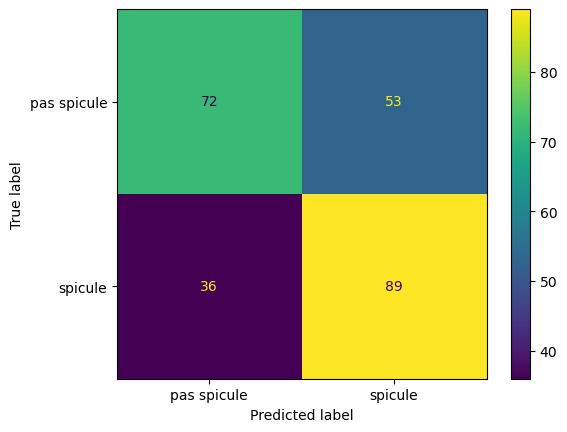

In [10]:
#Matrice de confusion 
cm=np.array([[classpred["pas spicule"].count(True), classpred["pas spicule"].count(False)],
       [classpred["spicule"].count(False), classpred["spicule"].count(True)]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["pas spicule","spicule"])
disp.plot()
plt.show()

In [14]:
#Pour chaque image ayant été utilisée en test, si elle a été correctement identifiée
imagepredfrac=imagepred
imagepredfrac['pas spicule']=dict(sorted(imagepredfrac['pas spicule'].items(),key=lambda kv:sum(kv[1])/len(kv[1]))) #Tri de façon à amener les images avec le plus d'erreur en haut
imagepredfrac['spicule']=dict(sorted(imagepredfrac['spicule'].items(),key=lambda kv:sum(kv[1])/len(kv[1]))) 
imagepredfrac['pas spicule']={k: f"{sum(v)}/{len(v)}" for k, v in imagepredfrac['pas spicule'].items()}
imagepredfrac['spicule']={k: f"{sum(v)}/{len(v)}" for k, v in imagepredfrac['spicule'].items()}
imagepredfrac

{'pas spicule': {'Rotschild  2.2_NM147_miliole 250.jpg': '0/4',
  'D0066 RDB_P10F47_bolivinoides2x8.jpg': '0/4',
  '79_1.10_HUCC_P117.5A_32_Bolivina x230.jpg': '0/3',
  'Beage58_indet1x5.jpg': '0/2',
  'ANLI70_facies_1200.JPG': '0/2',
  'Fissure 250.jpg': '0/2',
  'type 300-0005-HS2-orbitoide.tif': '0/2',
  'Coupvray_Foram benthique 4000.jpg': '0/2',
  '030_1.2_INRAP1031_foram benthique indet x1,6.jpg': '0/2',
  '8_1.26_HUCC_P129 _NM414_foram cortex x300.jpg': '0/1',
  'IMG_0031.JPG': '0/1',
  '80 (3) Lespaux_Siderolithe_ MdP.jpg': '0/1',
  '301-0002-215-benthique.tif': '0/1',
  '-F550a-0015-7-orbitoides.tif': '0/1',
  '161_1.1b_P128A_NM389_rotalidé x300.jpg': '1/3',
  '016_1.2_INRAP1201_Ammobaculites x3,2.jpg': '1/3',
  '24_4_1_SD4HS6_Alveolinax300.jpg': '1/3',
  'stries x1 Vi.jpg': '1/3',
  'Rotschild 2.1_F11_128_trisérié 250.jpg': '2/5',
  'Fissure 300.jpg': '2/4',
  '306-0006-116-benthique.tif': '2/4',
  'foram x300.jpg': '1/2',
  '1.6_K8HU19_foram1x250.jpg': '1/2',
  'Vaise 1_18_1